# DATA CLEANING

### 1. PULIZIA PER VALIDITÀ ATTIVITÀ
### 2. SELEZIONO SOLO SAGGI SU MMP9 E SU VERSIONE UMANA
### (RIMOZIONE VALORI ATTIVITÀ NULLA)
### 3. PULIZIA IN BASE ALLA RELAZIONE CON ATTIVITÀ
### 4. SELEZIONE TIPO ATTIVITÀ
### 5. CONVERSIONE IN pAct
### 6.SELEZIONE TIPO DI SAGGIO B
### 7.VISUALIZZAZIONE DI TUTTI I DUPLICATI
### 8. ANALISI DUPLICATI CHIRALI
### 9. Controllo dei duplicati non chirali
### 10. UNIONE DUPLICATI CHIRALI E NON¶
### 11. UNIONE COMPOSTI UNICI CON DUPLICATI
### 12. LEVARE GLI IONI DEI SALI
### 13. SELEZIONE PER PESO MOLECOLARE

In [28]:
#allargamento display ed importazione librerie di interesse
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import glob
import io

/tmp/ipykernel_2079903/2182679113.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [29]:
#from myutilities import (prepare_bindingdb_dataframe, prepare_chembl_dataframe, prepare_pubchem_dataframe)
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
#from rdkit.Chem import Draw

In [30]:
def logizer(nM):
    M = float(nM)*(10**-9) #equivalenza da nanomolare (1*10-9) a molare (1) moltiplicando per 10-9
    p = -np.log10(M) #trasformazione da molarità a -log della molarità - lavorando con -log della M , si ha omogeneità con pCutoff molare
    return p 

In [98]:
home = '/raid/home/fdivaler/CW/'
file = '/raid/home/fdivaler/CW/HDAC.csv'
std_type = 'IC50'
purpose = 'CLASSIFICATION'

In [32]:
#importazione file csv relativo al dataset chembl
df_chembl = pd.read_csv(file, sep=';')
print(f"Dataset di partenza con {df_chembl.shape[0]} molecole e {df_chembl.shape[1]} colonne")
df_chembl.head()

Dataset di partenza con 9089 molecole e 48 colonne


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value
0,CHEMBL148769,NaN,None,357.37,0,2.87,21,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,6.00,NaN,NaN,UO_0000065,16.79,0.32,3.13,5.51,0,CHEMBL877713,Inhibitory activity on partially purified reco...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL325,Histone deacetylase 1,Homo sapiens,SINGLE PROTEIN,CHEMBL1145775,1,Scientific Literature,J Med Chem,2003,None,NaN,NaN,NaN,1.0
1,CHEMBL346414,NaN,None,407.50,0,4.03,17a,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,5.70,NaN,NaN,UO_0000065,13.99,0.27,1.67,5.63,0,CHEMBL877713,Inhibitory activity on partially purified reco...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL325,Histone deacetylase 1,Homo sapiens,SINGLE PROTEIN,CHEMBL1145775,1,Scientific Literature,J Med Chem,2003,None,NaN,NaN,NaN,2.0
2,CHEMBL3916454,NaN,None,379.46,0,2.89,BDBM207637,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,4.62,NaN,366840,UO_0000065,12.17,0.24,1.73,4.56,0,CHEMBL3887997,HDAC enzyme inhibitionAssay: HDAC enzyme inhib...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL325,Histone deacetylase 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3886535,37,BindingDB Patent Bioactivity Data,NaN,2016,None,NaN,NaN,NaN,24000.0
3,CHEMBL3936525,NaN,None,343.40,0,3.34,BDBM207805,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,5.95,NaN,367006,UO_0000065,17.31,0.32,2.61,7.06,0,CHEMBL3887997,HDAC enzyme inhibitionAssay: HDAC enzyme inhib...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL325,Histone deacetylase 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3886535,37,BindingDB Patent Bioactivity Data,NaN,2016,None,NaN,NaN,NaN,1135.0
4,CHEMBL327924,NaN,None,366.42,0,2.47,28c,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,5.40,NaN,NaN,UO_0000065,14.73,0.27,2.93,4.91,0,CHEMBL695136,Ability to inhibit recombinant human histone d...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL325,Histone deacetylase 1,Homo sapiens,SINGLE PROTEIN,CHEMBL1146704,1,Scientific Literature,Bioorg Med Chem Lett,2004,None,NaN,NaN,NaN,4.0


# DATA DESCRIPTION
'Molecule ChEMBL ID'
'Molecule Name'
'Molecule Max Phase'
'Molecular Weight'
'#RO5 Violations' VIOLAZIONI REGOLA DI LIPINSKI
'AlogP'
'Compound Key'
'Smiles' ISOMERICA o CANONICA
'Standard Type' TIPO ATTIVITÀ IC50 KI ECC..
'Standard Relation' --> "'='", "'>'", nan, "'<'", "'~'", "'<='"
'Standard Value'
'Standard Units' 
'pChEMBL Value'
'Data Validity Comment' SE NULLO RIMUOVERE LIGANDO
'Comment'
'Uo Units'
'Ligand Efficiency BEI'
'Ligand Efficiency LE',
'Ligand Efficiency LLE'
'Ligand Efficiency SEI'
'Potential Duplicate',
'Assay ChEMBL ID'
'Assay Description'
'Assay Type' # Binding (B) - Data measuring binding of compound to a molecular target, e.g. Ki, IC50, Kd.
'BAO Format ID'
'BAO Label'
'Assay Organism' --> 'None', 'Homo sapiens', 'Pichia pastoris', 'Oryctolagus cuniculus'
'Assay Tissue ChEMBL ID'
'Assay Tissue Name'
'Assay Cell Type'
'Assay Subcellular Fraction'
'Assay Parameters'
'Assay Variant Accession'
'Assay Variant Mutation' --> tutti nan
'Target ChEMBL ID' solo CHEMBL321 che corrisponde a MMP9 umana
'Target Name'
'Target Organism' solo Homo sapiens
'Target Type' 
'Document ChEMBL ID'
'Source ID'
'Source Description'
'Document Journal'
'Document Year'
'Cell ChEMBL ID'
'Properties',
'Action Type'
'Standard Text Value'

In [33]:
df_chembl.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Standard Text Value', 'V

# What is the Data Validity column?

The flags currently in use in this field are:

Potential missing data

Potential author error

Manually validated

Potential transcription error

Outside typical range

Non standard unit for type

Author confirmed error


## VALUTAZIONE AFFIDABILITÀ DEL SAGGIO

In [34]:
df_chembl['Data Validity Comment']

0                                 NaN
1                                 NaN
2                                 NaN
3                                 NaN
4                                 NaN
5                                 NaN
6                                 NaN
7                                 NaN
8                                 NaN
9                                 NaN
10                                NaN
11                                NaN
12                                NaN
13                                NaN
14                                NaN
15                                NaN
16                                NaN
17                                NaN
18                                NaN
19                                NaN
20                                NaN
21                                NaN
22                                NaN
23                                NaN
24                                NaN
25                                NaN
26          

In [35]:
df_chembl['Data Validity Comment'].value_counts()

Outside typical range            54
Potential transcription error     6
Name: Data Validity Comment, dtype: int64

In [36]:
df_chembl['Data Validity Comment'].unique() 

array([nan, 'Outside typical range', 'Potential transcription error'],
      dtype=object)

# 1. PULIZIA PER VALIDITÀ ATTIVITÀ
## Rimuovo elementi al di fuori del range tipico perchè probabilmente presentano errori

In [37]:
#visualizzazione outliers
outliers = df_chembl[df_chembl['Data Validity Comment'].notnull()][['Standard Type', 'Standard Relation', 'Standard Value' , 'Standard Units' , 'Data Validity Comment']] 
outliers['Data Validity Comment'].value_counts() 

Outside typical range            54
Potential transcription error     6
Name: Data Validity Comment, dtype: int64

In [38]:
outliers.head()

,Standard Type,Standard Relation,Standard Value,Standard Units,Data Validity Comment
195,IC50,'=',191000.0,nM,Outside typical range
368,IC50,'>',180000.0,nM,Outside typical range
767,IC50,'=',1231000.0,nM,Outside typical range
768,IC50,'>',300000.0,nM,Outside typical range
931,IC50,'=',4100000.0,nM,Outside typical range


In [39]:
outliers.shape

(60, 5)

In [40]:
#seleziono solo righe in cui ho commento nullo
df_chembl = df_chembl[df_chembl['Data Validity Comment'].isnull()].copy() 
df_chembl.shape[0] 

9029

In [41]:
df_chembl.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088],
           dtype='int64', length=9029)

In [42]:
df_chembl = df_chembl.reset_index(drop=True)

In [43]:
df_chembl.index

RangeIndex(start=0, stop=9029, step=1)

In [44]:
print(f"Dataset ridotto dopo eliminazione degli outliers a {df_chembl.shape[0]} molecole e {df_chembl.shape[1]} righe")

Dataset ridotto dopo eliminazione degli outliers a 9029 molecole e 48 righe


# 2. SELEZIONO SOLO SAGGI SU DYRK1B E SU VERSIONE UMANA 
## A volte sono presenti saggi su altre isoforme o su versioni animali del target in esame.


In [45]:
df_chembl['Assay Organism'].value_counts()

Homo sapiens    8041
None             988
Name: Assay Organism, dtype: int64

In [46]:
assay_desc = list(df_chembl['Assay Description'].unique())

In [47]:
assay_no_correct = []
#controllo che siano saggi su MMP9
for assay in assay_desc:
    if '1' not in assay:
        print(assay)
        assay_no_correct.append(assay)
        #gelatinase B è MMP9 quindi unica che non va bene è Inhibition of MMP1

Inhibition of human recombinant HDAC2
Enzyme Assay: The assay have been carried out in a 96 well format and the BIOMOL using a fluorescent-based HDAC activity assay.
Inhibition of HDAC activity measured by HDAC Fluorescent Activity Assay (mean of two experiments)
In vitro inhibition of histone deacetylase activity using HeLa cell nuclear extract as enzyme source


In [48]:
df_chembl = df_chembl[~df_chembl['Assay Description'].isin(assay_no_correct)]

In [49]:
df_chembl.reset_index(drop=True, inplace=True)

In [50]:
df_chembl.shape

(8799, 48)

## Da capire se prendere in considerazione solo i primi due o tutti (provenienti da saggi differenti)

In [51]:
df_chembl['Assay Description'].value_counts()

Inhibition of HDAC1 (unknown origin)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [52]:
df_chembl['Assay Organism'].value_counts()

Homo sapiens    7811
None             988
Name: Assay Organism, dtype: int64

In [53]:
for assay in assay_desc:
    if 'human' not in assay:
        print(assay)
        # non posso fare cosi perchè a volte non è definito se umano o no e poi ci potrebbero essere organismi ricombinati  

HDAC enzyme inhibitionAssay: HDAC enzyme inhibition assays were performed using purified HDACs 1-10 essentially as described in Beckers et al., 2007, Int. J. Cancer., 121:1138-48 and Perez-Balado et al., 2007, J. Med. Chem., 50:2497-2505. Inhibition assays using nuclear extract were performed essentially as described in Herman et al., 2006, Nat. Chem. Biol., 2:551-558. Briefly, the purified HDACs or nuclear extract were incubated with an acetylated substrate in the absence of the compound to be assayed and with increasing concentrations of the compound. The rate of substrate deacetylation was measured under each condition, and half-maximal inhibitory concentration with regard to each HDAC was determined by standard means.
Inhibition of full length recombinant HDAC1 using Fluor de Lys as substrate by fluorescence assay
Inhibition of HDAC1 (unknown origin)
Inhibition of HDAC1
Inhibition of recombinant HDAC1 using Ac-Lys(Ac)-AMC as substrate after 30 mins by fluorescence analysis
Inhibiti

# 3. RIMOZIONE VALORI ATTIVITÀ NULLA

In [54]:
#selezione colonne utili e rimozione nan
df_chembl = df_chembl[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value' , 'Standard Units' , 'Assay Type']]
df_chembl = df_chembl.dropna()
df_chembl.isna().any()

Molecule ChEMBL ID    False
Smiles                False
Standard Type         False
Standard Relation     False
Standard Value        False
Standard Units        False
Assay Type            False
dtype: bool

In [55]:
df_chembl.reset_index(drop=True, inplace=True)

In [56]:
df_chembl.shape

(8587, 7)

# 3. PULIZIA IN BASE ALLA RELAZIONE CON ATTIVITÀ
* CLASSIFICAZIONE: si tengono maggiori anche maggiori e minori di (dividendo o moltiplicando per due) e i minori uguali di che: lascio cosi come sono
* REGRESSIONE: si tengono solo uguali di che hanno un valore certo
* 3DQSAR : si tengono quelli con valore certo come per la regressione ma se abbiamo valori minori di unità di misura nanomolare (10 alla -9) si tengono perchè è meglio l'incertezza che la perdita di informazione

In [57]:
df_chembl['Standard Relation'].value_counts() 

'='     7657
'>'      876
'<'       52
'>='       2
Name: Standard Relation, dtype: int64

In [58]:
purpose

'CLASSIFICATION'

In [59]:
if purpose == 'REGRESSION':
    df_chembl = df_chembl[df_chembl['Standard Relation'] == "'='"]
else:pass    

In [60]:
df_chembl.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay Type
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B


In [61]:
df_chembl.shape

(8587, 7)

In [62]:
df_chembl.index

RangeIndex(start=0, stop=8587, step=1)

In [63]:
df_chembl = df_chembl.reset_index(drop=True)

In [64]:
df_chembl.index

RangeIndex(start=0, stop=8587, step=1)

# 4. SELEZIONE TIPO ATTIVITÀ

In [65]:
df_chembl['Standard Type'].value_counts()

IC50    8587
Name: Standard Type, dtype: int64

In [66]:
df_chembl = df_chembl[df_chembl['Standard Type']== std_type]
df_chembl = df_chembl.reset_index(drop = True)
df_chembl.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay Type
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B


In [67]:
df_chembl.shape

(8587, 7)

In [68]:
df_chembl.index

RangeIndex(start=0, stop=8587, step=1)

### Converion from ug.mL-1 to nM
#### ug == g/1000000
#### mL == L/1000
#### therefore:
#### 1 ug/mL = g/1000000*1000/L == g/(1000*L)
#### to convert in molarity we have to dived the weight by the MW:
#### 1 ug/mL == g/(1000*MW) == M ==>>  M * 1000000000 == nM

# 5. CONVERSIONE IN pAct
## Per valori maggiori o minori di si fa per due o divisio due in classificazione

In [69]:
def logizer(nM):
    M = float(nM)*(10**-9) #equivalenza da nanomolare (1*10-9) a molare (1) moltiplicando per 10-9
    p = -np.log10(M) #trasformazione da molarità a -log della molarità - lavorando con -log della M , si ha omogeneità con pCutoff molare
    return p

In [70]:
def logizer_classification(nM, relation):
    
    #più alta è la IC50 più concentrazione mi serve per inibire il 50% del bersaglio
    #se minore quindi molecola più attiva
    #se maggiore molecola meno attiva
    
    if relation == "'<'":
        nM_correct = nM/2 #IC50 minore di X divido per due 
    elif relation == "'>'":
        nM_correct = nM*2#IC50 maggiore di X moltiplico per due
    elif relation == "'='" or relation == "'~'" or relation == "'>='" or relation == "'<='":
        nM_correct = nM
   
    
    print(nM, relation, nM_correct)
    
    M = float(nM_correct)*(10**-9) #equivalenza da nanomolare (1*10-9) a molare (1) moltiplicando per 10-9
    p = -np.log10(M) #trasformazione da molarità a -log della molarità - lavorando con -log della M , si ha omogeneità con pCutoff molare
    return p 

In [71]:
df_chembl['MW'] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(i)) for i in df_chembl['Smiles']] 

In [72]:
df_chembl.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay Type,MW
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B,357.132471
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B,407.130363
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B,379.136591
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B,343.169605
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B,366.169191


In [73]:
df_chembl['Standard Units'].unique()

array(['nM', 'ug.mL-1'], dtype=object)

In [74]:
df_chembl['Standard Units'].value_counts()

nM         8584
ug.mL-1       3
Name: Standard Units, dtype: int64

In [75]:
df_chembl['Standard Relation'].value_counts() 

'='     7657
'>'      876
'<'       52
'>='       2
Name: Standard Relation, dtype: int64

In [76]:
df_chembl['Standard Relation'].unique()

array(["'='", "'>'", "'<'", "'>='"], dtype=object)

In [77]:
nM_act = []
for n, SU in enumerate(df_chembl['Standard Units']):
    if SU == 'nM': 
        nM = df_chembl['Standard Value'][n]
        nM_act.append(nM)
    if SU == 'µM':#micro è già 10 alla meno 6 mentre nano è 10 alla -9 moli
        print('µM', df_chembl['Standard Value'][n])
        µM = df_chembl['Standard Value'][n]
        nM = float(µM)*(10**3)
        nM_act.append(nM)
    if SU ==  'ug.mL-1': 
        print('ug.mL-1', df_chembl['Standard Value'][n])
        print('MW', df_chembl['MW'][n])# a mano controllo se funziona bene la conversione
        nM = df_chembl['Standard Value'][n]/df_chembl['MW'][n]*1000000
        nM_act.append(nM)
    print(n, SU, nM)

0 nM 1000.0
1 nM 2000.0
2 nM 24000.0
3 nM 1135.0
4 nM 4000.0
5 nM 7.12
6 nM 72.0
7 nM 125.0
8 nM 385.0
9 nM 210.0
10 nM 197.0
11 nM 34.0
12 nM 1060.0
13 nM 37.0
14 nM 0.4
15 nM 2.8
16 nM 35.6
17 nM 12.3
18 nM 13.5
19 nM 100.0
20 nM 4800.0
21 nM 680.0
22 nM 1700.0
23 nM 1800.0
24 nM 25000.0
25 nM 194.0
26 nM 25.0
27 nM 51.0
28 nM 250.0
29 nM 8000.0
30 nM 90.0
31 nM 13.7
32 nM 4.0
33 nM 187.0
34 nM 4312.0
35 nM 248.0
36 nM 4000.0
37 nM 2.0
38 nM 135.0
39 nM 95.0
40 nM 10.0
41 nM 17300.0
42 nM 730.0
43 nM 200.0
44 nM 35.0
45 nM 94.0
46 nM 18.6
47 nM 14.5
48 nM 97.8
49 nM 55.0
50 nM 14700.0
51 nM 900.0
52 nM 1270.0
53 nM 8.0
54 nM 1140.0
55 nM 800.0
56 nM 32.0
57 nM 1450.0
58 nM 33.0
59 nM 4700.0
60 nM 160.0
61 nM 13000.0
62 nM 250.0
63 nM 50000.0
64 nM 578.0
65 nM 80.0
66 nM 153.0
67 nM 5.0
68 nM 8.5
69 nM 45.0
70 nM 26.7
71 nM 27.0
72 nM 1100.0
73 nM 90.0
74 nM 8800.0
75 nM 1500.0
76 nM 153.0
77 nM 17000.0
78 nM 380.0
79 nM 580.0
80 nM 10000.0
81 nM 92.0
82 nM 214.0
83 nM 4320.0
84 nM 16

In [78]:
purpose

'CLASSIFICATION'

In [79]:
if purpose == 'CLASSIFICATION':    
    pAct = []
    for n, SU in enumerate(df_chembl['Standard Units']):
        if SU == 'nM': 
            nM = df_chembl['Standard Value'][n]
            relation = df_chembl['Standard Relation'][n]
            pAct.append(logizer_classification(nM, relation))

        if SU == 'µM':
            µM = df_chembl['Standard Value'][n]
            nM = float(µM)*(10**3)
            relation = df_chembl['Standard Relation'][n]
            pAct.append(logizer_classification(nM, relation))            

        if SU ==  'ug.mL-1': 
            nM = df_chembl['Standard Value'][n]/df_chembl['MW'][n]*1000000
            relation = df_chembl['Standard Relation'][n]
            pAct.append(logizer_classification(nM, relation)) 
        #print(n, SU, nM, logizer(nM))
else:pass                        

1000.0 '=' 1000.0
2000.0 '=' 2000.0
24000.0 '=' 24000.0
1135.0 '=' 1135.0
4000.0 '=' 4000.0
7.12 '=' 7.12
72.0 '=' 72.0
125.0 '=' 125.0
385.0 '=' 385.0
210.0 '=' 210.0
197.0 '=' 197.0
34.0 '=' 34.0
1060.0 '=' 1060.0
37.0 '=' 37.0
0.4 '=' 0.4
2.8 '=' 2.8
35.6 '=' 35.6
12.3 '=' 12.3
13.5 '=' 13.5
100.0 '=' 100.0
4800.0 '=' 4800.0
680.0 '=' 680.0
1700.0 '=' 1700.0
1800.0 '=' 1800.0
25000.0 '>' 50000.0
194.0 '=' 194.0
25.0 '=' 25.0
51.0 '=' 51.0
250.0 '=' 250.0
8000.0 '=' 8000.0
90.0 '=' 90.0
13.7 '=' 13.7
4.0 '=' 4.0
187.0 '=' 187.0
4312.0 '=' 4312.0
248.0 '=' 248.0
4000.0 '=' 4000.0
2.0 '=' 2.0
135.0 '=' 135.0
95.0 '=' 95.0
10.0 '=' 10.0
17300.0 '=' 17300.0
730.0 '=' 730.0
200.0 '=' 200.0
35.0 '=' 35.0
94.0 '=' 94.0
18.6 '=' 18.6
14.5 '=' 14.5
97.8 '=' 97.8
55.0 '=' 55.0
14700.0 '=' 14700.0
900.0 '=' 900.0
1270.0 '=' 1270.0
8.0 '=' 8.0
1140.0 '=' 1140.0
800.0 '=' 800.0
32.0 '=' 32.0
1450.0 '=' 1450.0
33.0 '=' 33.0
4700.0 '=' 4700.0
160.0 '=' 160.0
13000.0 '=' 13000.0
250.0 '=' 250.0
5000

In [80]:
len(pAct)

8587

In [81]:
if purpose == 'REGRESSION':    
    pAct = []
    for n, SU in enumerate(df_chembl['Standard Units']):
        if SU == 'nM': 
            nM = df_chembl['Standard Value'][n]
            pAct.append(logizer(nM))

        if SU == 'µM':
            µM = df_chembl['Standard Value'][n]
            nM = float(µM)*(10**3)
            pAct.append(logizer(nM))

        if SU ==  'ug.mL-1': 
            nM = df_chembl['Standard Value'][n]/df_chembl['MW'][n]*1000000
            pAct.append(logizer(nM))
        #print(n, SU, nM, logizer(nM))
else: pass        

In [82]:
df_chembl['Standard Value nM'] = nM_act
df_chembl['pAct'] = pAct

In [83]:
df_chembl.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay Type,MW,Standard Value nM,pAct
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B,357.132471,1000.0,6.000000
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B,407.130363,2000.0,5.698970
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B,379.136591,24000.0,4.619789
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B,343.169605,1135.0,5.945004
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B,366.169191,4000.0,5.397940


In [84]:
df_chembl.index

RangeIndex(start=0, stop=8587, step=1)

# 6. SELEZIONE TIPO DI SAGGIO B
Selezionare saggi B, IC50 e nM preliminarmente sia per consistenza numerica sia per manipolare dati omogenei, soprattutto nel passaggio dei duplicati

In [85]:
# visualizzazione del numero di record sottoposti a ciascun tipo di saggio
df_chembl['Assay Type'].value_counts() 
#saggia A sono quelli in vivo con somministrazione

B    8363
A     224
Name: Assay Type, dtype: int64

In [86]:
assay_type = 'B'

In [87]:
df_chembl = df_chembl.loc[df_chembl['Assay Type'] == assay_type].copy() #selezione classe F perche dati cellulari 

In [88]:
df_chembl['Standard Type'].value_counts() #controllo std type

IC50    8363
Name: Standard Type, dtype: int64

In [89]:
df_chembl.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay Type,MW,Standard Value nM,pAct
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B,357.132471,1000.0,6.000000
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B,407.130363,2000.0,5.698970
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B,379.136591,24000.0,4.619789
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B,343.169605,1135.0,5.945004
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B,366.169191,4000.0,5.397940


In [90]:
#ridenominazione colonne
df_chembl.columns = ['ID', 'ISOMERIC SMILES', 'STANDARD TYPE','STANDARD RELATION', 'STANDARD VALUE', 'STANDARD UNITS', ' ASSAY TYPE', 'MW', 'STANDARD VALUE [nM]', 'pAct']

In [91]:
df_chembl.head()

,ID,ISOMERIC SMILES,STANDARD TYPE,STANDARD RELATION,STANDARD VALUE,STANDARD UNITS,ASSAY TYPE,MW,STANDARD VALUE [nM],pAct
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B,357.132471,1000.0,6.000000
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B,407.130363,2000.0,5.698970
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B,379.136591,24000.0,4.619789
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B,343.169605,1135.0,5.945004
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B,366.169191,4000.0,5.397940


In [92]:
df_chembl.shape

(8363, 10)

In [93]:
df_chembl = df_chembl.reset_index(drop=True)

In [94]:
df_chembl.index

RangeIndex(start=0, stop=8363, step=1)

In [95]:
!mkdir /home/robertastolfi/HDAC/HDAC1

mkdir: cannot create directory ‘/home/robertastolfi/HDAC/HDAC1’: No such file or directory


In [97]:
with open(home+'/Selezione_dati_attivita.pickle', 'wb') as f:
    pickle.dump(df_chembl, f)

In [99]:
imported = pickle.load(open(home+'/Selezione_dati_attivita.pickle', 'rb'))

<AxesSubplot:>

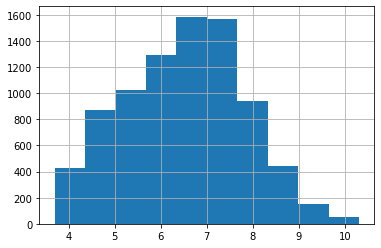

In [100]:
imported['pAct'].hist()

In [102]:
imported.head()

,ID,ISOMERIC SMILES,STANDARD TYPE,STANDARD RELATION,STANDARD VALUE,STANDARD UNITS,ASSAY TYPE,MW,STANDARD VALUE [nM],pAct
0,CHEMBL148769,COc1ccc(NC(=O)Nc2ccc(/C=C/C(=O)NO)cc2)cc1OC,IC50,'=',1000.0,nM,B,357.132471,1000.0,6.000000
1,CHEMBL346414,Cc1ccc(NS(=O)(=O)c2ccc(/C=C/C(=O)Nc3ccccc3N)cc...,IC50,'=',2000.0,nM,B,407.130363,2000.0,5.698970
2,CHEMBL3916454,Nc1ccccc1NC(=O)CCCCCNS(=O)(=O)c1ccc(F)cc1,IC50,'=',24000.0,nM,B,379.136591,24000.0,4.619789
3,CHEMBL3936525,Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1F,IC50,'=',1135.0,nM,B,343.169605,1135.0,5.945004
4,CHEMBL327924,Nc1ccccc1NC(=O)CCCCCn1c(=O)[nH]c2ccccc2c1=O,IC50,'=',4000.0,nM,B,366.169191,4000.0,5.397940
